In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [27]:
df_count = pd.read_csv("results/hochuli/new_count.csv")
df_original = pd.read_csv("results/hochuli/original.csv")
df_diff = pd.read_csv("results/hochuli/diff.csv")

In [28]:
# fazendo a média por execução (cada época aparece num_execucoes)
df_count = df_count.groupby("epoch").mean()
df_original = df_original.groupby("epoch").mean()
df_diff = df_diff.groupby("epoch").mean()

In [29]:
# splitting training and test
df_count_train = df_count[df_count.index != -1]
df_count_test = df_count[df_count.index == -1]
df_original_train = df_original[df_original.index != -1]
df_original_test = df_original[df_original.index == -1]
df_diff_train = df_diff[df_diff.index != -1]
df_diff_test = df_diff[df_diff.index == -1]

## Frequência da ReLU

In [30]:
df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]

/tmp/ipykernel_4956/2529414924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]


In [31]:
from model_utils import Hochuli
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parâmetros: {count_parameters(Hochuli([3, 28, 28], 10, nn.ReLU()))}")

Número de parâmetros: 73418


In [32]:
relu_proportion = df_count_train["zero_relu_call"].sum() / df_count_train["total_relu_call"].sum()
print(f"Proporção Média da ReLU: {relu_proportion}    1/{round(1/relu_proportion):_}")
print(f"Total de Ponto Não Diff: {round(df_count_train['zero_relu_call'].sum()):_} / {round(df_count_train['total_relu_call'].sum()):_}")

Proporção Média da ReLU: 7.645901490367138e-06    1/130_789
Total de Ponto Não Diff: 403_850 / 52_819_200_000


In [33]:
sns.set_style("whitegrid", {'axes.grid' : True})

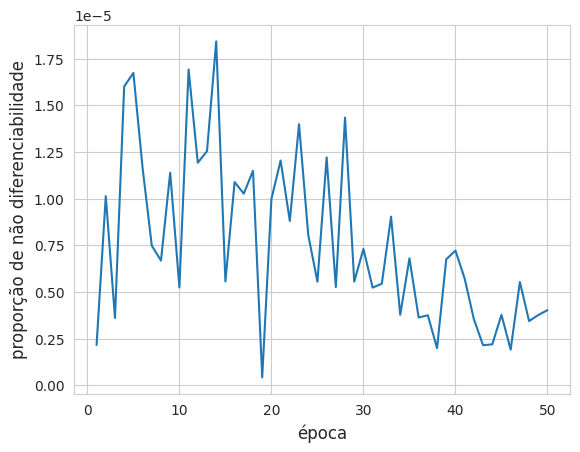

In [34]:
ax = sns.lineplot(data=df_count_train, x="epoch", y="relu_proportion")
ax.set_xlabel("época", fontsize=12)
ax.set_ylabel("proporção de não diferenciabilidade", fontsize=12)
plt.savefig('relu_proportion.eps', format='eps')

## Comparando com funções diferenciáveis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


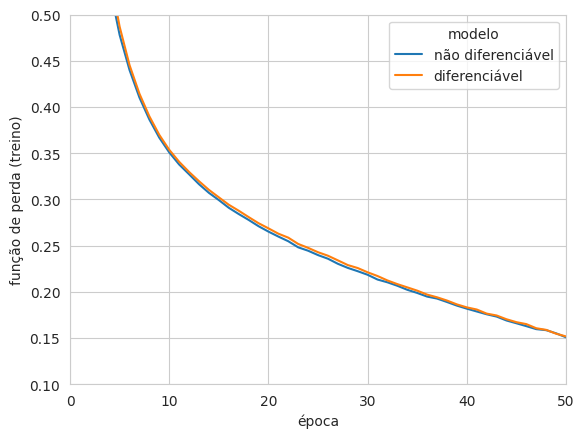

In [35]:
temp = pd.DataFrame()
temp["original"] = df_original_train["train_loss"]
temp["diff"] = df_diff_train["train_loss"]
temp["epoch"] = df_diff_train.index
temp = pd.melt(temp, ["epoch"])
temp = temp.rename(columns={"variable": "modelo"})
temp["modelo"] = temp["modelo"].replace("original", "não diferenciável")
temp["modelo"] = temp["modelo"].replace("diff", "diferenciável")
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="modelo")
ax.set(xlabel="época", ylabel="função de perda (treino)")
ax.set_xlim(0, 50)
ax.set_ylim(0.1, 0.5)
plt.savefig('train_loss.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


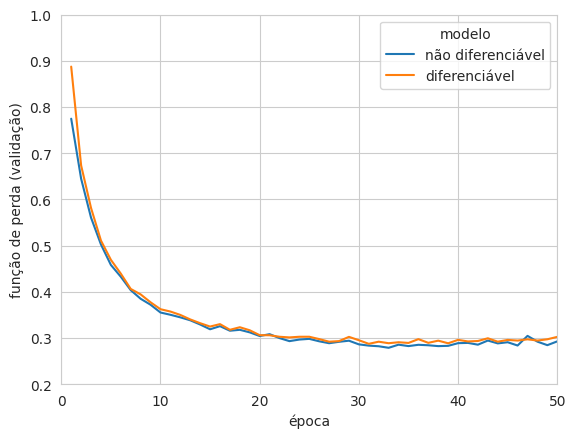

In [36]:

temp = pd.DataFrame()
temp["original"] = df_original_train["val_loss"]
temp["diff"] = df_diff_train["val_loss"]
temp["epoch"] = df_diff_train.index
temp = pd.melt(temp, ["epoch"])
temp = temp.rename(columns={"variable": "modelo"})
temp["modelo"] = temp["modelo"].replace("original", "não diferenciável")
temp["modelo"] = temp["modelo"].replace("diff", "diferenciável")
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="modelo")
ax.set(xlabel="época", ylabel="função de perda (validação)")
ax.set_xlim(0, 50)
ax.set_ylim(0.2, 1)
plt.savefig('val_loss.eps', format='eps')

In [37]:
best_original = df_original_train[df_original_train["val_loss"] == df_original_train["val_loss"].min()]
best_diff = df_diff_train[df_diff_train["val_loss"] == df_diff_train["val_loss"].min()]

linhas = ["best_epoch", "test_acc", "avg_train_time", "test_time"]

data_original = [best_original.index[0]]
data_original.append(df_original_test["val_acc"].mean())
data_original.append(df_original_train["time"].mean())
data_original.append(df_original_test["time"].mean()/10000)
data_original

data_diff = [best_diff.index[0]]
data_diff.append(df_diff_test["val_acc"].mean())
data_diff.append(df_diff_train["time"].mean())
data_diff.append(df_diff_test["time"].mean()/10000)

data = {"não diff": data_original, "diff": data_diff}

df = pd.DataFrame(data=data, index=linhas)
df["diferença"] = 100 * (df["diff"] - df["não diff"]) / df["não diff"]
df

,não diff,diff,diferença
best_epoch,33.000000,31.000000,-6.060606
test_acc,0.899280,0.898640,-0.071168
avg_train_time,13.406512,13.309574,-0.723061
test_time,0.000171,0.000178,4.184181
